# Grupo: Fabio Grassiotto, Euline Marcos Rodrigues, Luis Antônio Prado
# Disciplina: IA369Y, 2ºS 2017
# Projeto: Emoções em Bolsas de Valores

O objetivo deste projeto foi procurar relacionar a valência das notícias relativas ao mercado financeiro à flutuação de valor das ações na bolsa.

As idéias que seguimos neste projeto foram:
- A partir da coleta de mensagens do twitter ou sites de notícias verificar o impacto no mercado de ações
- Restringir ao mercado americano, devido as APIs e corpus disponíveis
- Somente empresas de tecnologia com ações na NASDAQ
- Descobrir se realmente existe correlação entre os dados.

## 1. Seleção das empresas de tecnologia

Selecionamos as 10 empresas negociadas na bolsa de Nova Iorque com a maior valor de mercado:

- Apple
- Google
- Microsoft
- Facebook
- Taiwan Semiconductor (a maior fábrica de semicondutores do mundo)
- Cisco
- Intel
- Oracle
- IBM
- SAP

## 2. Obtenção das notícias relacionadas às empresas

A primeira dificuldade encontrada foi obter as notícias de tecnologia relacionadas às empresas acima. As principais APIs utilizadas para esse propósito (Google Finance e Yahoo) não estão mais em operação. 
Felizmente, o site Intrinio oferece uma API que permite a extração de notícias históricas com seleção por empresa.

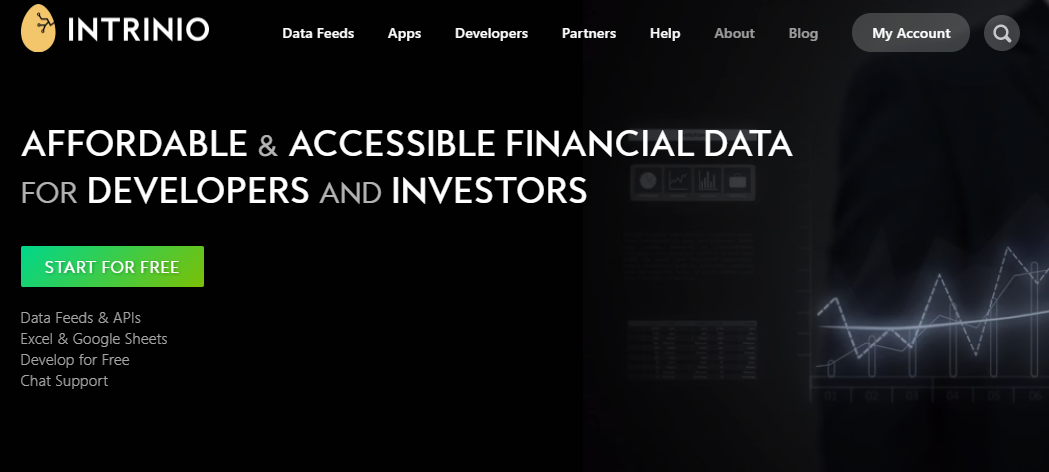

In [1]:
from IPython.display import Image
Image("images/intrinio-site.png")

Utilizando o código abaixo, as notícias foram extraídas e gravadas em arquivos CSV, um por empresa, para processamento posterior.

```
# %load intrinio-fetch.py
# Script para extrair dados de notícias do site intrinio
# das 10 ações de tecnologia com maor Market Cap negociadas na NASDAQ.
import intrinio

# O site intrinio fornece acesso à API através de username e senha
# a API tem limites de utilização diária, por isso duas contas foram utilizadas
# para executar o fetch.
#intrinio.client.username = 'cbf3647ca29bd2236958b388b875b9fd'
#intrinio.client.password = '932441d13c084642d3bfece69acb1227'

intrinio.client.username = '9ef28500250f001837e864630f98010d'
intrinio.client.password = 'b6d38989841c00d252232a7ef1822f20'

# Extrai notícias em dataframe pandas e grava em CSV.
df_appl = intrinio.news('AAPL')
df_appl.to_csv('news/AAPL.csv')
df_googl = intrinio.news('GOOGL')
df_googl.to_csv('news/GOOGL.csv')
df_msft = intrinio.news('MSFT')
df_msft.to_csv('news/MSFT.csv')
df_fb = intrinio.news('FB')
df_fb.to_csv('news/FB.csv')
df_tsm = intrinio.news('TSM')
df_tsm.to_csv('news/TSM.csv')
df_csco = intrinio.news('CSCO')
df_csco.to_csv('news/CSCO.csv')
df_intc = intrinio.news('INTC')
df_intc.to_csv('news/INTC.csv')
df_orcl = intrinio.news('ORCL')
df_orcl.to_csv('news/ORCL.csv')
df_ibm = intrinio.news('IBM')
df_ibm.to_csv('news/IBM.csv')
df_sap = intrinio.news('SAP')
df_sap.to_csv('news/SAP.csv')
```

O resultado da execução do código pode ser visualizado para a empresa AAPL. Apenas as coluna com o título da notícia e data de publicação foram selecionadas abaixo para visualização. 

In [2]:
import pandas as pd
df = pd.read_csv('news\AAPL.csv')
df = df [['title', 'publication_date']]
pd.set_option('display.max_rows', 10)
df

,title,publication_date
0,Israeli start-up says Apple copied its patente...,2017-11-07 22:32:13 +0000
1,Israeli start-up says Apple copied its patente...,2017-11-07 22:31:40 +0000
2,Here’s how much the iPhone X costs Apple to make,2017-11-07 22:14:28 +0000
3,"Here&apos;s How Much Debt Apple, Inc. Ended Up...",2017-11-07 22:00:00 +0000
4,"iPhone X Teardowns, Drop Tests Revealed Flawed...",2017-11-07 21:30:00 +0000
...,...,...
28934,Apple plans to sell $1 bln of 30-yr bonds in T...,2016-06-01 08:29:12 +0000
28935,India discussing Apple's request for FDI rules...,2016-05-30 17:05:39 +0000
28936,India says Apple must sell locally-sourced goo...,2016-05-25 17:48:27 +0000
28937,More challenges than cheer for Apple chief on ...,2016-05-24 08:42:12 +0000


Pode-se notar que a quantidade de notícias retornada é muito grande, com cerca de 30000 para a Apple. Algumas notícias são duplicadas, provavelmente por causa de sindicalização no mercado editorial digital.
Para resolver o problema de duplicação e agregar todas as notícias em um banco de dados para classificação, o código abaixo foi executado criando um banco de dados no arquivo __news.db__.

In [3]:
# %load create-newsdb.py
# Script para criar um banco de dados sql-lite com as notícias relativas
# às ações de tecnologia.

import glob
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import MetaData

if os.path.exists('news.db'):
    os.remove('news.db')

news_files = glob.glob('news/*.csv')

# Conexão com db
disk_engine = create_engine('sqlite:///news.db')

for file in news_files:
    df = pd.read_csv(file)
    df = df[['ticker', 'publication_date', 'title']]
    # Remove entradas duplicadas
    df = df.drop_duplicates(subset='title', keep="last")
    df.to_sql('news_table', disk_engine, if_exists='append')

m = MetaData()
m.reflect(disk_engine)
print('News Database:')
for table in m.tables.values():
    print("Tabela: {0}".format(table.name))
    print("Colunas:")
    for column in table.c:
        print(column.name)
    

News Database:
Tabela: news_table
Colunas:
index
ticker
publication_date
title


## 3. Obtenção dos valores de ações na Nasdaq

Por utilizar notícias de um periodo especifico, resolvemos pegar os valores de ações neste mesmo periodo. O site da Nasdaq disponibilizar uma ferramenta de busca de empresas. Para cada empresa, a ferramenta de busca disponibiliza varias informações:

![Site da Nasdaq](images/nasdaq-site.png)

Na opção Historical Quote, é possivel fazer a busca no historico de cotação da empresa e fazer o download dos dados no formato csv.

A leitura dos dados também é feita utilizando a lib pandas:

In [4]:
import pandas as pd

csvData = pd.read_csv("nasdaqHistorical/FB_Historical.csv")
pd.set_option('display.max_rows', 10)
csvData

,date,close,volume,open,high,low
0,16:00,177.95,"10,219,409",176.75,178.5700,176.40
1,2017/11/14,178.07,9535750.0000,178.13,178.9700,177.18
2,2017/11/13,178.77,9514524.0000,177.50,179.0400,177.30
3,2017/11/10,178.46,11058700.0000,178.35,179.0999,177.96
4,2017/11/09,179.30,12599830.0000,178.31,179.4000,177.09
...,...,...,...,...,...,...
394,2016/04/26,108.76,22393840.0000,110.49,110.5000,108.15
395,2016/04/25,110.10,20997040.0000,109.87,110.6700,109.07
396,2016/04/22,110.56,38397070.0000,111.21,111.7500,109.01
397,2016/04/21,113.44,20711310.0000,112.55,114.0400,112.31


In [5]:
csvData = csvData.reindex(index=csvData.index[::-1])

Para este experimento vamos utilizar apenas os valores da coluna "close" que corresponde ao valor de fechamento das ações do dia da coluna "date".

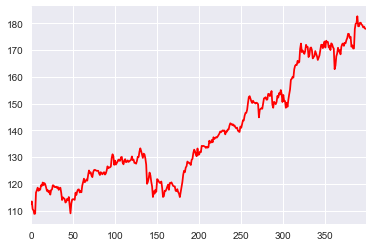

In [6]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
#csvData = csvData.reindex(index=csvData.index[::-1])
sns.tsplot(data=csvData.close, color="r")
plt.show()

## 4. Resultados

O sentimento das notícias foi então classificado utilizando quatro bases de dados diferentes:

1. Sentiwordnet
2. Afinn
3. Base da biblioteca TextBlob - Pattern.en
4. VADER (Valence Aware Dictionary and sEntiment Reasoner)

Para as duas primeiras bases, foi utilizado para classificação o algoritmo Multinomial de Bayes da biblioteca Scikit-Learn, que é conhecido por ter boa performance na classificação multi-classe de textos. 

As duas últimas bases são classificadores léxicos por regras.

### 4.1 Sentiwordnet

A base Sentiwordnet tem cerca de 120 mil termos, com classificação de valência positiva e negativa.

```
ID         PosScore  NegScore    SynsetTerms  label
0          0.125     0.000           able      1
1          0.000     0.750         unable     -7
2          0.000     0.000         dorsal      0
3          0.000     0.000        ventral      0
4          0.000     0.000     acroscopic      0
....
117652     0.000     0.250         plague     -2
117653     0.000     0.000          swamp      0
117654     0.000     0.000        run_dry      0
117655     0.000     0.125         fog_up     -1
117656     0.000     0.000           coal      0
117657     0.125     0.250           haze     -1
117658     0.125     0.000     deflagrate      1
```

Para classificação, foram criadas classes de valências obtidas a partir da subtração da valência negativa da positiva e multiplicada por 10, obtendo a seguinte distribuição:

```
Classe  Qty
 0     89805
 1      5145
-1      4704
 2      3242
-2      3139
-3      2137
 3      1982
-5      1963
-6      1586
 5      1508
-7       935
 6       791
 7       325
-8       246
 8       116
 10       19
-10       16
```
Pode-se notar que a maior parte dos termos no corpus classifica as palavras como neutras, o que vai gerar uma distribuição similar na classificação das notícias.
Executando o classificador obtemos abaixo:

In [7]:
# %load classify-senti.py
# Script para executar classificação das manchetes relacionadas a ações.
# Base: Sentiwordnet 3.0
import pandas as pd
import nltk
import re
from pandas import DataFrame
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sqlalchemy import create_engine

# Transforma scores positivos/negativos em valência
def create_label(row):
    return int(10*(row['PosScore'] - row['NegScore']))

# Stemming
def stem_tokens(tokens, stemmer):
    stemmed = [stemmer.stem(item) for item in tokens]
    return(stemmed)

# Tokenização
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return(stems)

# Leitura do sentiwordnet 3.0 em um dataframe e manipulação dos dados.
# Após a manipulação ficamos com as colunas na tabela: Pos Neg Word
df = pd.read_csv('SentiWordNet_3.0.0_20130122.txt', comment = '#', sep='\t')
df.drop(df.columns[[0, 1, 5]], axis=1, inplace=True)
df.drop(df.tail(1).index,inplace=True)

# Processamento do wordnet para obter um label único para cada palavra...
df['label'] = df.apply (lambda row: create_label (row),axis=1)

# Test Data
engine = create_engine('sqlite:///news.db')
table_name = 'news_table'
test_df = pd.read_sql_table(table_name, engine)

stemmer = PorterStemmer()

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english'
)

train_data = df['SynsetTerms']
train_labels = df['label']
test_data = test_df['title']

train_vectors = vectorizer.fit_transform(train_data.values.astype('U'))
test_vectors = vectorizer.transform(test_data.values.astype('U'))

# Classificação
classifier = MultinomialNB(alpha=0.01)
classifier.fit(train_vectors, train_labels)
prediction = classifier.predict(test_vectors)
probabilities = classifier.predict_proba(test_vectors)

# Output
s = pd.Series(prediction)
print(s.value_counts())

test_df['valence'] = prediction  

# Escreve a classificação no banco de dados.
test_df = test_df.drop('index', axis = 1)
test_df.to_sql('news_table', engine, if_exists='replace')

# Cria tabela para identificar o classificador empregado.
class_df = pd.DataFrame(['SentiwordNet'], columns=['classifier'])
class_df.to_sql('classifier_table', engine, if_exists='replace')

 0     80371
 1      5163
 5      1379
-1       831
 3       677
       ...  
 8        65
-8        55
-7        53
 10        6
-10        1
Length: 17, dtype: int64


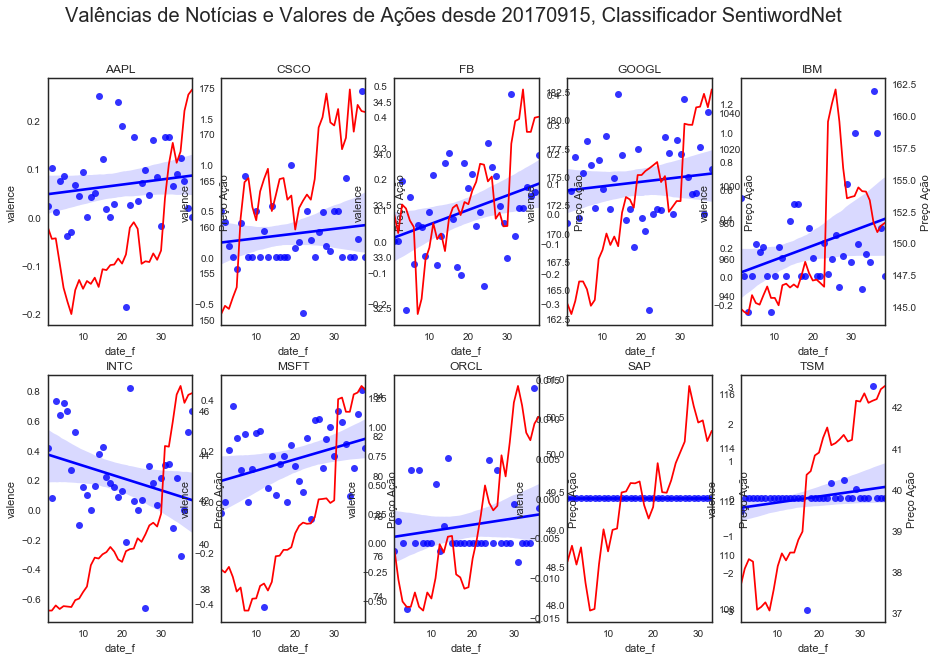

In [8]:
%run plot-graphs.py 20170915

Podemos notar que para este classificador a correlação não pode ser observada.

## 4.2 AFINN

A base de dados AFINN foi construída para a análise de textos de microblogs. A base classifica as palavras com valências entre -5 e +5. É uma base muito menor, com cerca de 3500 palavras apenas:
```
0         abandon -2
1       abandoned -2
2        abandons -2
3        abducted -2
4       abduction -2
5      abductions -2
6           abhor -3
7        abhorred -3
...
3376     youthful  2
3377        yucky -2
3378        yummy  3
3379       zealot -2
3380      zealots -2
3381      zealous  2
```

As valências da base são distribuídas conforme abaixo:
```
-2    1411
 2     627
-3     376
-1     354
 1     246
 3     233
 4      65
-4      47
-5      16
 5       5
 0       2
 ```
 Nota-se que esta base tende mais para a valência negativa, sem convcentração no neutro como a SentiWordNet.
 Executando o classificador obtemos o resultado abaixo:

In [9]:
# %load classify-afinn.py
# Script para executar classificação das manchetes relacionadas a ações.
import pandas as pd
import nltk
import re
from pandas import DataFrame
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sqlalchemy import create_engine

# Transforma scores positivos/negativos em label.
def create_label(row):
    if (row['PosScore']-row['NegScore']) == 0:
        return 'Neutral'
    elif (row['PosScore']-row['NegScore']) > 0:
        return 'Positive'
    else:
        return 'Negative'

# Stemming
def stem_tokens(tokens, stemmer):
    stemmed = [stemmer.stem(item) for item in tokens]
    return(stemmed)

# Tokenização
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return(stems)

# Leitura do AFINN em um dataframe e manipulação dos dados.
# Após a manipulação ficamos com as colunas na tabela: Word Valence
df = pd.read_csv('AFINN-en-165.txt', header=None, sep='\t')

# Test Data
engine = create_engine('sqlite:///news.db')
table_name = 'news_table'
test_df = pd.read_sql_table(table_name, engine)

stemmer = PorterStemmer()

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english'
)

train_data = df[0]
train_labels = df[1]
test_data = test_df['title']

train_vectors = vectorizer.fit_transform(train_data.values.astype('U'))
test_vectors = vectorizer.transform(test_data.values.astype('U'))

# Classificação
classifier = MultinomialNB()
classifier.fit(train_vectors, train_labels)
prediction = classifier.predict(test_vectors)

# Output
s = pd.Series(prediction)
print(s.value_counts())

test_df['valence'] = prediction  

# Escreve a classificação no banco de dados.
test_df = test_df.drop('index', axis = 1)
test_df.to_sql('news_table', engine, if_exists='replace')

# Cria tabela para identificar o classificador empregado.
class_df = pd.DataFrame(['AFINN'], columns=['classifier'])
class_df.to_sql('classifier_table', engine, if_exists='replace')

-2    57797
 2    19601
-1     4435
 1     4298
-3     3858
 3      900
 4       21
dtype: int64


Nota-se uma distribuição de valências mais negativa que no caso anterior.
Plotando novamente os gráficos de comparação dos valores de ações e sentimento, obtemos abaixo:

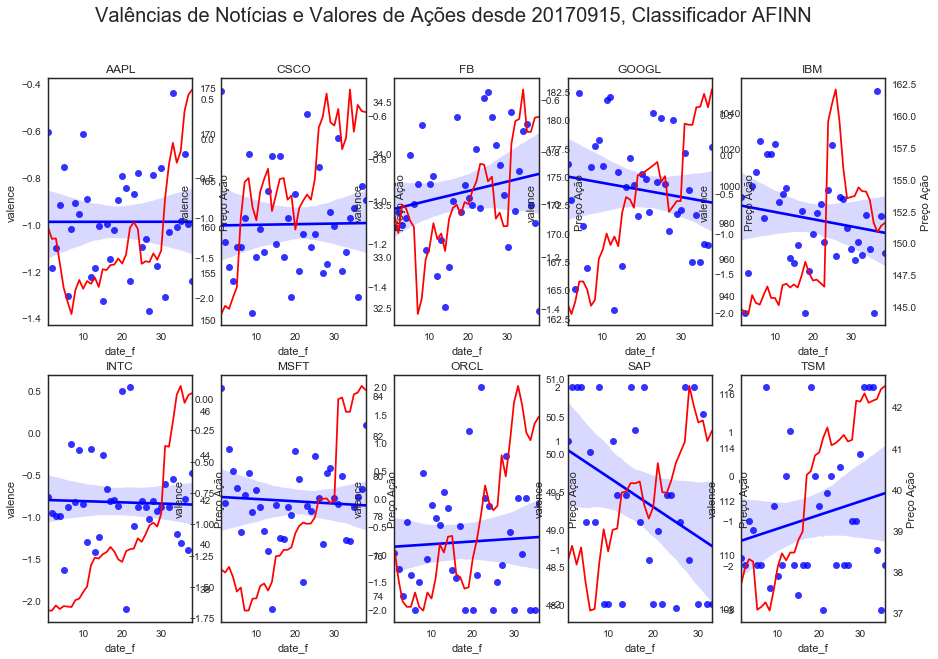

In [10]:
%run plot-graphs.py 20170915

Obtem-se um resultado similar à base anterior. A correlação não pode ser verificada.

## 4.3 TextBlob/Pattern.En

A biblioteca Python TextBlob oferece uma API simplificada para tarefas de classificação de texto.
Internamente, esta biblioteca utiliza o classificador léxico da Pattern.En, que contém um léxico de adjetivos que ocorrem frequentemente em análises de produtos, anotados com valências e subjetividade.

Executando o classificador obtemos agora:

In [11]:
# %load classify-textblob.py
# Script para executar classificação das manchetes relacionadas a ações.
import pandas as pd
from sqlalchemy import create_engine
from textblob import TextBlob

# Test Data
engine = create_engine('sqlite:///news.db')
table_name = 'news_table'
test_df = pd.read_sql_table('news_table', engine)

test_df['valence'] = test_df.apply(lambda x: TextBlob(x['title']).sentiment.polarity, axis=1)

# Output
print(test_df['valence'].value_counts())

# Escreve a classificação no banco de dados.
test_df = test_df.drop('index', axis = 1)
test_df.to_sql('news_table', engine, if_exists='replace')

# Cria tabela para identificar o classificador empregado.
class_df = pd.DataFrame(['TextBlob/Pattern.En'], columns=['classifier'])
class_df.to_sql('classifier_table', engine, if_exists='replace')

0.000000    52778
0.500000     4516
0.136364     3112
0.250000     2042
0.100000     1467
            ...  
0.047222        1
0.040278        1
0.140000        1
0.012500        1
0.241667        1
Name: valence, Length: 1391, dtype: int64


Plotando novamente os gráficos de comparação dos valores de ações e sentimento, obtemos abaixo:

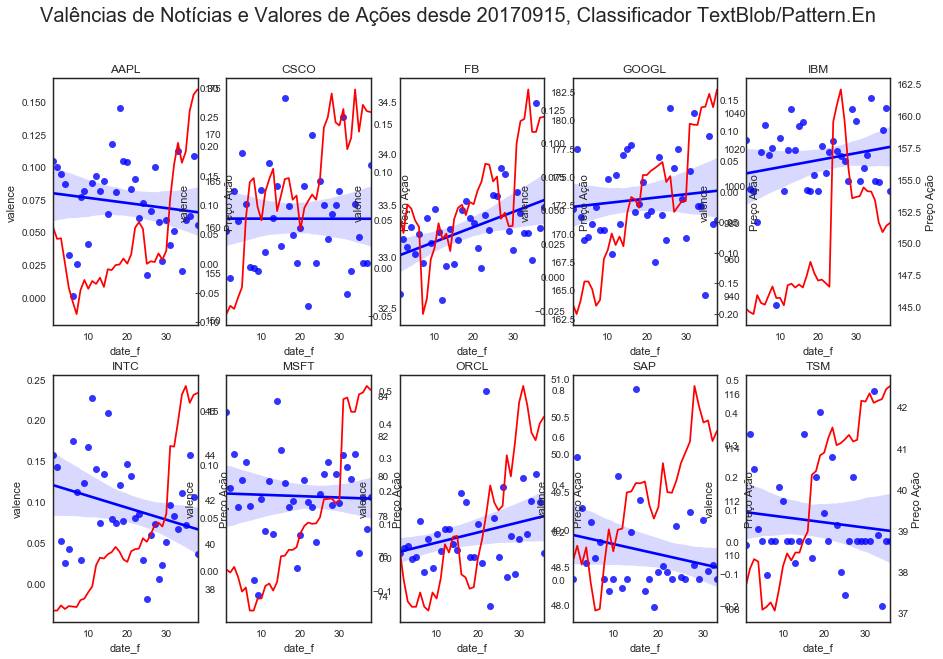

In [12]:
%run plot-graphs.py 20170915

Não se percebe correlação entre a valência e a flutuação dos valores das ações.

## 4.4 VADER (Valence Aware Dictionary and sEntiment Reasoner)

VADER (Valence Aware Dictionary e sEntiment Reasoner) é uma ferramenta de análise de sentimento baseada em léxico e regras, especificamente desencvolvida para análise de sentimentos em mídias sociais. O corpus contém cerca de 7500 palavras, classificadas em valência.

Executando o classificador obtemos como saída:

In [13]:
# %load classify-vader.py
# Script para executar classificação das manchetes relacionadas a ações.
import pandas as pd
from sqlalchemy import create_engine
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Test Data
engine = create_engine('sqlite:///news.db')
table_name = 'news_table'
test_df = pd.read_sql_table('news_table', engine)

vader = SentimentIntensityAnalyzer()

test_df['valence'] = test_df.apply(lambda x: vader.polarity_scores(x['title'])['compound'], axis=1)

# Output
print(test_df['valence'].value_counts())

# Escreve a classificação no banco de dados.
test_df = test_df.drop('index', axis = 1)
test_df.to_sql('news_table', engine, if_exists='replace')

# Cria tabela para identificar o classificador empregado.
class_df = pd.DataFrame(['VADER'], columns=['classifier'])
class_df.to_sql('classifier_table', engine, if_exists='replace')

 0.0000    43563
 0.1779     1933
 0.2023     1746
 0.4019     1643
 0.2960     1603
           ...  
-0.5308        1
 0.4509        1
-0.5927        1
-0.5141        1
 0.6318        1
Name: valence, Length: 1118, dtype: int64


Notamos que o classificador tem um espalhamento mais uniforme na faixa de valência.
Plotando novamente os gráficos de comparação dos valores de ações e sentimento, obtemos:

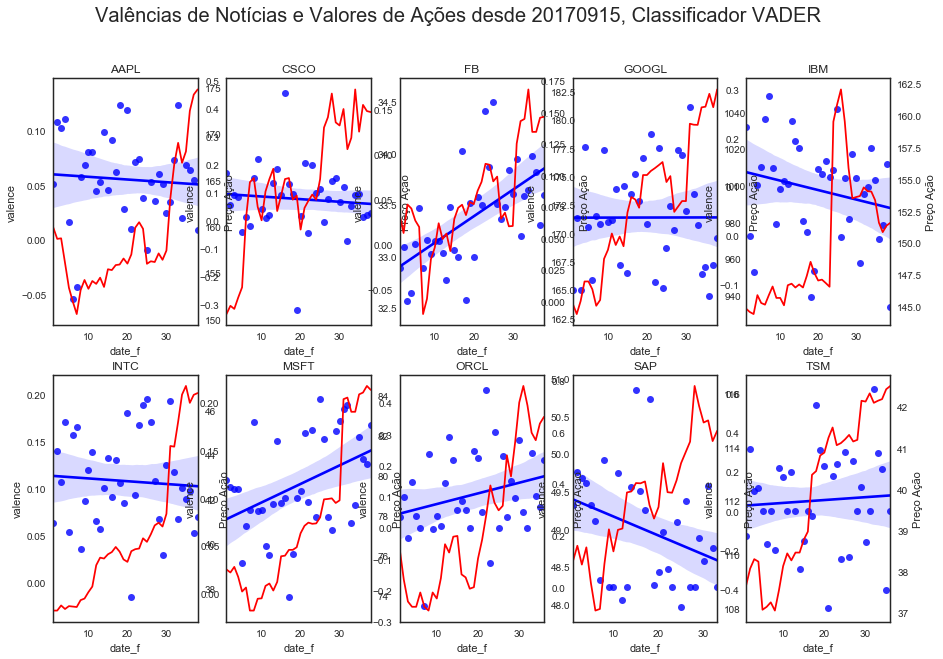

In [14]:
%run plot-graphs.py 20170915

Não existe novamente uma correlação entre a valência e a flutuação das ações no mercado.

## 5. Análise das Valências

Plotando todas as valências obtidas para as notícias para o classificador VADER, obtemos o gráfico de espalhamento abaixo:

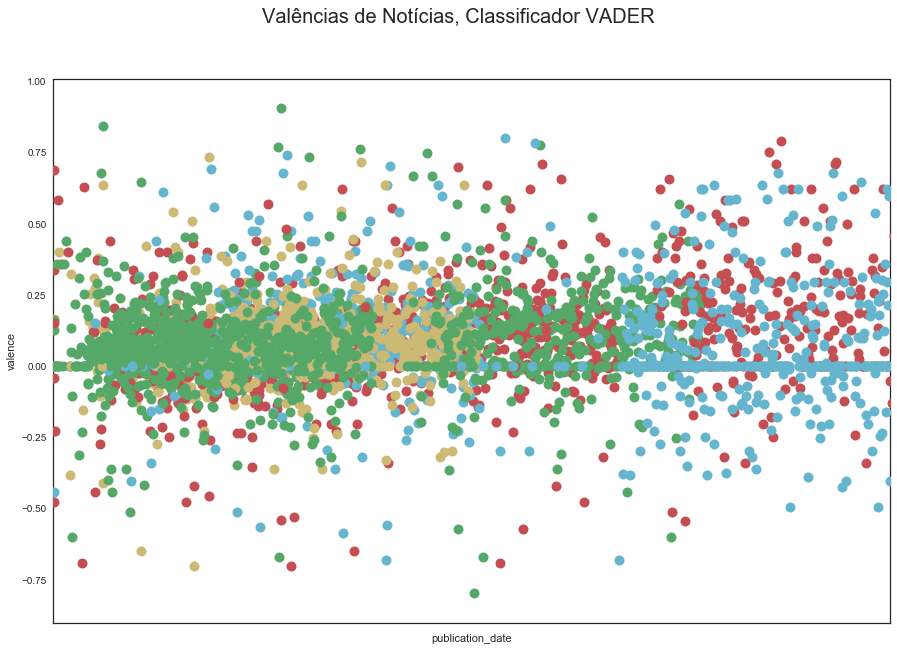

In [15]:
%run plot-valences.py

Nota-se um espalhamento muito claro em torno da média central, o que leva à conclusão que as valências médias são neutras, dificultando a correlação.

## 6. Conclusões

- A valência de notícias de mercado tende a ser neutra, a menos que tenha ocorrido algum fato isolado relativo à empresa no mercado. Isso dificulta bastante a análise de correlação.

    > *A imprensa procura compensar negatividade?*

- Não encontramos um corpus representativo para a análise de notícias do mercado financeiro, o que prejudicou a classificação.
    > *A maior parte dos corpus disponíveis são apropriados para social media, principalmente twitter.*

- A correlação das variações de valências e valor de ações não é aparente.
	> *Outras estratégias de correlação poderiam ser usadas.*

- Outras “features” para análise poderiam ser incluídas, como por exemplo tweets, impressões de redes sociais.
    > *“Press Releases” das empresas costumam ter impacto mais profundo sobre o valor da ação.*

- O ciclo de vida de uma ação também precisa ser considerado.
	> *Ups e Downs no mercado são comuns.*
    
## 7. Lições Aprendidas

- Classificador
    > *A decisão de se fazer uma classificação por valência prejudicou o resultado obtido. Uma alternativa seria a mudança do modelo emocional.*
- Dataset
    > *A construção de um dataset também específico voltado para notícias sobre o mercado de ações ainda não foi feito.*
- Investidores
    > *Apenas 11% dos investidores são pessoas físicas. 
Os "reais" investidores têm outras fontes de informação para tomada de decisões.*

## 8. Trabalhos futuros no assunto

- Causalidade de Clive Granger (modelo de correlações)
- Modelo emocional voltado para mercado de ações
- Dataset específico para mercado de ações
- Modelagem da tomada de decisões dos grandes investidores

# Referências

* Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

* Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

* JJ Zhai, NN Cohen, A Atreya, "CS224N Final Project: Sentiment analysis of news articles for financial signal prediction"

* Johan Bollen,Huina Mao,Xiao-Jun Zeng, "Twitter mood predicts the stock market", Journal of computational science, 2011

* RP Schumaker, H Chen, "Textual Analysis of Stock Market Prediction Using Breaking Financial News: The AZFinText System", ACM Transactions, 2009

* TH Nguyen, K Shiraia, J Velcin, "Sentiment analysis on social media for stock movement prediction", Expert Systems with Applications, 2015

* Q Li, B Zhou, Q Liu, "Can Twitter Posts Predict Stock Behavior?", IEEE International Conference on Cloud Computing and Big Data Analysis, 2016

* Site da base SentiwordNet: http://sentiwordnet.isti.cnr.it/

* Github da base de dados AFINN: https://github.com/fnielsen/afinn

* Site da biblioteca TextBlob: https://textblob.readthedocs.io/en/dev/

* Biblioteca Pattern.En: https://www.clips.uantwerpen.be/pages/pattern-en

* Github do classificador VADER: https://github.com/cjhutto/vaderSentiment
